In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import minmax_scale
import cv2
import os
import shutil

import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

print(tf.__version__)
print(f'TensorFlow built with cuda? {tf.test.is_built_with_cuda()}')
print(f'TensorFlow built with GPU support? {tf.test.is_built_with_gpu_support()}')

2024-07-08 17:16:27.892779: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 17:16:27.918687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 17:16:27.918714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 17:16:27.919931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 17:16:27.924611: I tensorflow/core/platform/cpu_feature_gua

2.16.2
TensorFlow built with cuda? True
TensorFlow built with GPU support? True


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

2024-07-08 17:16:29.666206: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 17:16:29.701637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 17:16:29.701867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
base_dir = './images/overlap'

images_dir ='./images/overlap/tiles'
masks_dir = './images/overlap/masks'

images_listdir = [img for img in os.listdir(images_dir) if img.endswith('jpg')]
masks_listdir = [img for img in os.listdir(masks_dir) if img.endswith('jpg')]

print(len(images_listdir))
print(len(masks_listdir))

521
521


In [4]:
img_train, img_test = train_test_split(images_listdir, test_size=0.20)
len(img_train)

416

In [5]:
masks_train, masks_test = train_test_split(masks_listdir, test_size=0.20)
len(masks_train)

416

In [6]:
img_train_path = os.path.join(images_dir, 'train')

if not os.path.isdir(img_train_path):
    os.makedirs(img_train_path)

for img in img_train:
    src = os.path.join(images_dir, img)
    dst = os.path.join(img_train_path, img)
    shutil.copyfile(src, dst)


img_test_path = os.path.join(images_dir, 'test')

if not os.path.isdir(img_test_path):
    os.makedirs(img_test_path)

for img in img_test:
    src = os.path.join(images_dir, img)
    dst = os.path.join(img_test_path, img)
    shutil.copyfile(src, dst)

In [7]:
masks_train_path = os.path.join(masks_dir, 'train')

if not os.path.isdir(masks_train_path):
    os.makedirs(masks_train_path)

for img in masks_train:
    src = os.path.join(masks_dir, img)
    dst = os.path.join(masks_train_path, img)
    shutil.copyfile(src, dst)

masks_test_path = os.path.join(masks_dir, 'test')

if not os.path.isdir(masks_test_path):
    os.makedirs(masks_test_path)

for img in masks_test:
    src = os.path.join(masks_dir, img)
    dst = os.path.join(masks_test_path, img)
    shutil.copyfile(src, dst)

In [8]:
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [9]:
image_size = 512
input_image_size = (image_size, image_size)

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

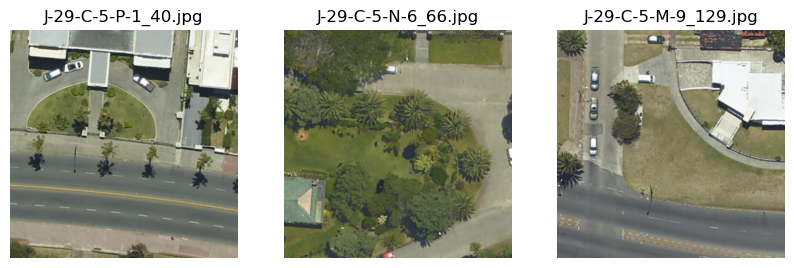

In [10]:
rows = 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10, 10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        input_path = f"{images_dir}/{random_images[i]}"
        img = read_image(input_path)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

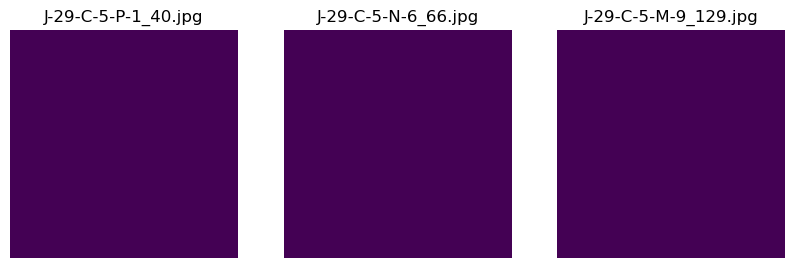

In [11]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [14]:
MASKS = np.zeros((1, image_size, image_size, 1), dtype=bool)
IMAGES = np.zeros((1, image_size, image_size, 3), dtype=np.uint8)


for j, file in enumerate(img_train):   ##the smaller, the faster
    image = read_image(f"{img_train_path}/{file}")
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])
    file2 = file[0:-4]+'.jpg'
    mask = read_image(f"{masks_dir}/{file2}")
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(image_size, image_size, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    MASKS = np.vstack([MASKS, mask_ex])

In [15]:
TMASKS = np.zeros((1, image_size, image_size,1), dtype=bool)
TIMAGES = np.zeros((1, image_size, image_size,3),dtype=np.uint8)

for j, file in enumerate(img_test):
    image = read_image(f"{img_test_path}/{file}")
    image_ex = np.expand_dims(image, axis=0)
    TIMAGES = np.vstack([TIMAGES, image_ex])
    file2 = file[0:-4]+'.jpg'
    mask = read_image(f"{masks_dir}/{file2}")
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(image_size, image_size, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    TMASKS = np.vstack([TMASKS, mask_ex])

In [16]:
images=np.array(IMAGES)
masks=np.array(MASKS)
print('Train')
print(images.shape, masks.shape)

test_images=np.array(TIMAGES)
test_masks=np.array(TMASKS)

print('Test')
print(test_images.shape, test_masks.shape)

Train
(417, 512, 512, 3) (417, 512, 512, 1)
Test
(106, 512, 512, 3) (106, 512, 512, 1)


In [17]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.2, random_state=42)

In [18]:
print(len(images_train), len(masks_train))

333 333


In [19]:
# from tensorflow.keras import backend as K
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.optimizers import Adam

from tensorflow import keras

def iou_coeff(y_true, y_pred):
    # Calcula la intersección entre el y_true y y_pred
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    # Calcula la unión
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    # Calcula el coeficiente de IoU
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return iou

def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)

    bridge = conv_block(pool3, 512)

    decode2 = decoder_block(bridge, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

In [20]:
unet_model = Unet((image_size, image_size, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy')
unet_model.summary()

2024-07-08 17:17:44.416913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 17:17:44.417353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 17:17:44.417569: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [21]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 2, epochs = 20)

Epoch 1/3


I0000 00:00:1720469886.299919   14547 service.cc:145] XLA service 0x77c94c039fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720469886.299947   14547 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2024-07-08 17:18:06.440330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 17:18:06.990668: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-07-08 17:18:12.631539: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-08 17:18:14.265879: W external/local_tsl/tsl/framework/bfc_a

266/266 ━━━━━━━━━━━━━━━━━━━━ 131s 371ms/step - loss: -64.4137 - val_loss: -1608.9071
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 99s 371ms/step - loss: -173.2120 - val_loss: -6471.3667
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 99s 373ms/step - loss: -276.3890 - val_loss: -6069.8613


In [24]:
unet_model.save('./modelos/unet_512_3epochs_cpu.keras')